In [1]:
from prometheus_pandas import query
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


#Time Interval


In [2]:
global start, end
start = '2023-03-23T19:00:00Z'
end = '2023-03-23T19:10:00Z'

start2 = '2023-03-24T02:15:00Z'
end2 = '2023-03-24T02:25:00Z'

#Latency

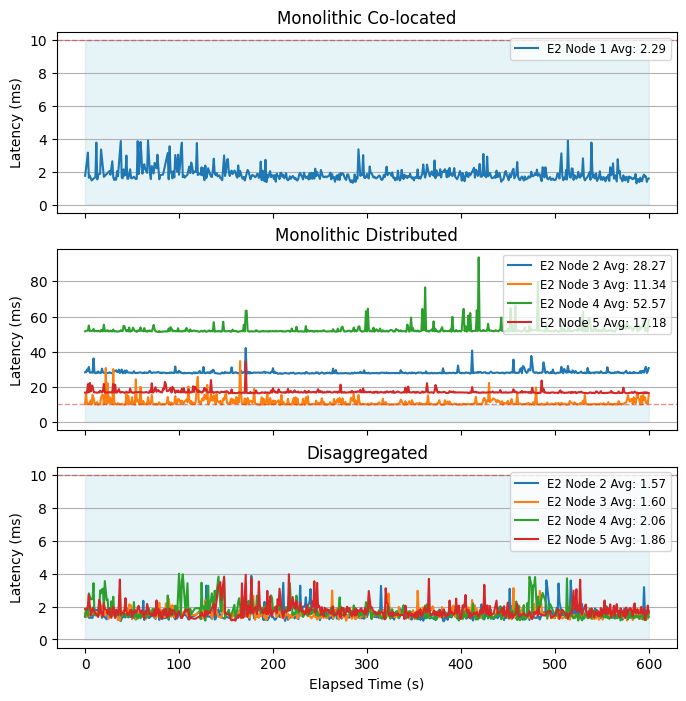

In [3]:
# Function to process and plot the data
def process_and_plot(df, start, xlabel, ylabel, ax, filter, title):
    # Rename columns
    column_mapping = {
        '{SIM_ID="1"}': 'E2 Node 1',
        '{SIM_ID="2"}': 'E2 Node 2',
        '{SIM_ID="3"}': 'E2 Node 3',
        '{SIM_ID="4"}': 'E2 Node 4',
        '{SIM_ID="5"}': 'E2 Node 5',
    }
    df = df.rename(columns=column_mapping)

    # Convert latency from seconds to milliseconds
    df = df * 1000

    # Add average latency to column names
    for col in df.columns:
        avg_latency = df[col].mean()
        df.rename(columns={col: f"{col} Avg: {avg_latency:.2f}"}, inplace=True)

    # Convert start string to datetime object and make it timezone-aware
    start_dt = pd.to_datetime(start)
    start_dt = start_dt.replace(tzinfo=df.index.tz)

    # Convert DateTime index to elapsed time in seconds
    df.index = pd.to_timedelta(df.index - start_dt).total_seconds()
    index = df.index[df.apply(lambda x: (x > filter).any(), axis=1)]  # Update threshold to 3 ms
    df.drop(index, inplace=True)

    # Plot the filtered data
    df.plot(kind='line', ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.legend(fontsize='small', loc='upper right')

    # Add horizontal line at 10 ms and fill the area below it
    ax.axhline(10, color='tab:red', linestyle='--', linewidth=1, alpha=0.5)
    ax.fill_between(df.index, 0, 10, alpha=0.3, color='lightblue')

    ax.yaxis.grid(True)#, color='gray', linestyle='--', linewidth=0.5, zorder=-1)



# Create subplots
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

# First graph
df0 = pd.read_csv(start + '-out-latency.csv',index_col=0)
df0.index = pd.to_datetime(df0.index)
df0 = df0[['{SIM_ID="1"}']]
process_and_plot(df0, start, 'Elapsed Time (s)', 'Latency (ms)', axes[0], 4, "Monolithic Co-located")

# Second graph
df1 = pd.read_csv(start + '-out-latency.csv',index_col=0)
df1.index = pd.to_datetime(df1.index)
df1.drop(columns='{SIM_ID="1"}', inplace=True)
process_and_plot(df1, start, 'Elapsed Time (s)', 'Latency (ms)', axes[1], 100, "Monolithic Distributed")

# Third graph
df2 = pd.read_csv(start2 + '-out-latency.csv',index_col=0)
df2.index = pd.to_datetime(df2.index)
df2.drop(columns='{SIM_ID="1"}', inplace=True)
process_and_plot(df2, start2, 'Elapsed Time (s)', 'Latency (ms)', axes[2], 4, "Disaggregated")

# Save plots
plt.savefig('control-looping-latency.pdf', bbox_inches='tight')
plt.savefig('control-looping-latency.png', dpi=300, bbox_inches='tight')
